In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import utils
import matplotlib.pyplot as plt

In [2]:
args = {}
args["data_dir"] = "data/Segmentation01_RGB"
args["data"] = "segmentation01"
args["lr"] = 0.001
utils.split_train_to_val(args["data"], args["data_dir"], val_ratio=0.1)

In [3]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["train", "val"]
        )

In [4]:
import timm
class UNet(nn.Module):
    def __init__(self, num_classes=4, encoder_name='resnet18.a1_in1k'):
        super(UNet, self).__init__()
        self.encoder = timm.create_model(encoder_name, pretrained=True, features_only=True, out_indices=[0,1,2,3,4])

        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sequential(
                nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True),
            ),
            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sequential(
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True),
            )
        ])
        self.final_1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.final_2 = nn.Sequential(
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        self.act = nn.Sigmoid()

    def forward(self, x):
        encoder_features = []
        # print(f"{x.shape}", end=" -> ")
        encoder_features = self.encoder(x)
        x = encoder_features[-1].clone()
        # print(f"{x.shape}")
        
        for i, module in enumerate(self.decoder):
            # print(f"{x.shape}", end=" -> ")
            x = module(x)
            # print(f"{x.shape}")
            x = torch.cat([x, encoder_features[-(i + 2)]], dim=1)
        
        # Final convolution
        # print(f"{x.shape}", end=" -> ")    
        x = self.final_1(x)
        # print(f"{x.shape}")
        # print(f"{x.shape}", end=" -> ")
        x = self.upsample(x)
        # print(f"{x.shape}")
        # print(f"{x.shape}", end=" -> ")
        x = self.final_2(x)
        # print(f"{x.shape}")
        return self.act(x)

/Users/rishitoshsingh/miniconda3/envs/dl-asign/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def get_device(device_str):
    if device_str == "gpu" and torch.cuda.is_available():
        return torch.device("cuda")
    elif device_str == "cpu":
        return torch.device("cpu")
    elif device_str == "mps" and torch.backends.mps.is_available():
        return torch.device("mps")  # You can modify the GPU index if needed
    else:
        print("Warning: Invalid device option. Using CPU.")
        return torch.device("cpu")
device = get_device("mps")

In [15]:
model = UNet(num_classes=1)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
model = model.to(device)

In [16]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [17]:
images, masks = next(iter(dataloaders["train"]))
print(images.shape, masks.shape)

torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])


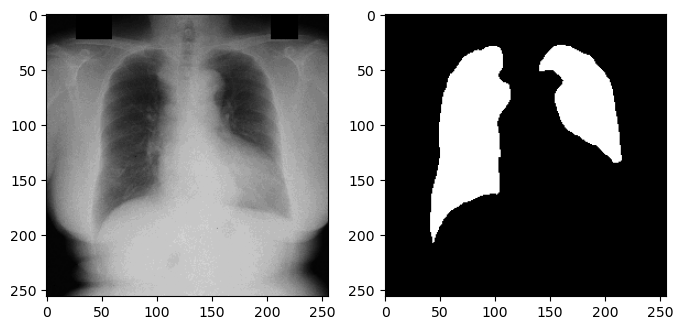

In [18]:
idx = 2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(121)
plt.imshow(image_to_arrag(images[idx]), cmap="gray")
fig.add_subplot(122)
plt.imshow(image_to_arrag(masks[idx]), cmap="gray")
plt.show()

In [19]:
from tqdm import tqdm

In [20]:
from torchsummary import summary
summary(model, (3, 224, 224))

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

In [21]:
def train_model(model, loss_fn, optimizer, dataloaders, dataser_sizes, num_epochs, mode):
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()
            running_loss=0.0
            with tqdm(total=len(dataloaders[phase]), desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase=="train"):
                        outputs = model(inputs.repeat(1, 3, 1, 1))
                        loss = loss_fn(outputs, labels)
                        if phase=="train":
                            loss.backward()
                            optimizer.step()
                        running_loss += loss.item()
                    pbar.update(1)
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, 10, "segmentation")

Val Epoch 1/10: 100%|██████████| 2/2 [00:11<00:00,  5.93s/batch]


Epoch 1/10 -> Train Loss: 0.1087, Val Loss: 0.1856


Val Epoch 2/10: 100%|██████████| 2/2 [00:11<00:00,  5.93s/batch]


Epoch 2/10 -> Train Loss: 0.0370, Val Loss: 0.0788


Val Epoch 3/10: 100%|██████████| 2/2 [00:12<00:00,  6.08s/batch]


Epoch 3/10 -> Train Loss: 0.0253, Val Loss: 0.1505


Val Epoch 4/10: 100%|██████████| 2/2 [00:12<00:00,  6.04s/batch]


Epoch 4/10 -> Train Loss: 0.0229, Val Loss: 0.0531


Val Epoch 5/10: 100%|██████████| 2/2 [00:12<00:00,  6.02s/batch]


Epoch 5/10 -> Train Loss: 0.0168, Val Loss: 0.0420


Val Epoch 6/10: 100%|██████████| 2/2 [00:11<00:00,  5.86s/batch]


Epoch 6/10 -> Train Loss: 0.0140, Val Loss: 0.0218


Val Epoch 7/10: 100%|██████████| 2/2 [00:11<00:00,  5.92s/batch]


Epoch 7/10 -> Train Loss: 0.0129, Val Loss: 0.0254


Val Epoch 8/10: 100%|██████████| 2/2 [00:11<00:00,  5.91s/batch]


Epoch 8/10 -> Train Loss: 0.0114, Val Loss: 0.0223


Val Epoch 9/10: 100%|██████████| 2/2 [00:12<00:00,  6.01s/batch]


Epoch 9/10 -> Train Loss: 0.0100, Val Loss: 0.0212


Val Epoch 10/10: 100%|██████████| 2/2 [00:11<00:00,  5.92s/batch]

Epoch 10/10 -> Train Loss: 0.0087, Val Loss: 0.0264


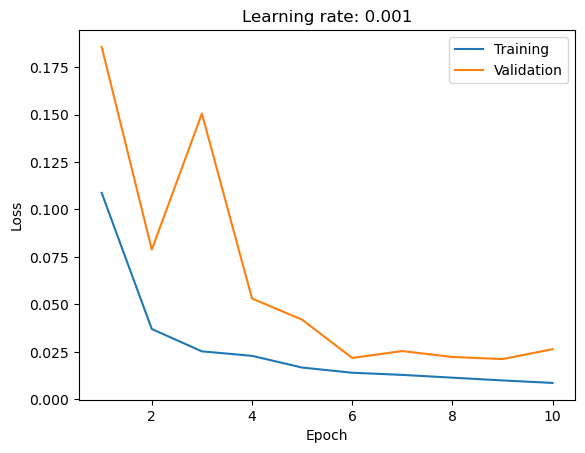

In [22]:
def plot_loss(train_losses, val_losses, learning_rate):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning rate: {learning_rate}")
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses, args["lr"])

In [23]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["test"]
        )

In [25]:
def test_model(model, loss_fn, dataloader, dataset_size):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    all_inputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.repeat(1,3,1,1))
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_targets.append(labels.cpu())
            all_inputs.append(inputs.cpu())
    test_loss = test_loss / dataset_size
    all_inputs, all_outputs, all_targets = torch.cat(all_inputs), torch.cat(all_outputs), torch.cat(all_targets)
    print(f"Test Loss: {test_loss:.4f}")
    return all_inputs, all_outputs, all_targets
inputs, outputs, targets = test_model(model, loss_fn, dataloaders["test"], dataset_sizes["test"])

Test Loss: 0.0175


In [26]:
def calculate_iou(pred_masks, true_masks, threshold=0.5):
    # Binarize predicted masks based on the threshold
    pred_masks = (pred_masks > threshold).float()

    intersection = torch.sum(pred_masks * true_masks, dim=(2, 3))  # Intersection
    union = torch.sum(pred_masks + true_masks, dim=(2, 3)) - intersection  # Union

    iou = intersection / (union + 1e-8)  # Add epsilon to avoid division by zero
    return torch.mean(iou)
print("mIoU: ", calculate_iou(outputs, targets, 0.5))

mIoU:  tensor(0.9333)


In [27]:
def calculate_dice(pred_masks, true_masks, threshold=0.5):
    # Binarize predicted masks based on the threshold
    pred_masks = (pred_masks > threshold).float()

    intersection = torch.sum(pred_masks * true_masks, dim=(2, 3))  # Intersection
    sum_masks = torch.sum(pred_masks + true_masks, dim=(2, 3))  # Sum of masks

    dice = 2. * intersection / (sum_masks + 1e-8)  # Add epsilon to avoid division by zero
    return torch.mean(dice)
print("mDICE: ", calculate_dice(outputs, targets, 0.5))

mDICE:  tensor(0.9655)


In [28]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [29]:
outputs=(outputs>0.5).float()

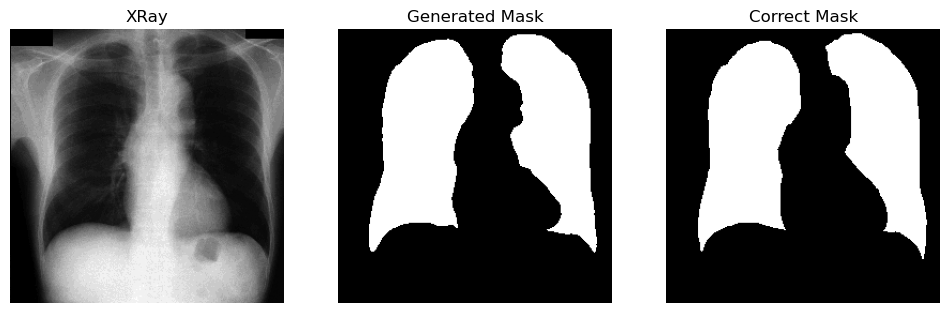

In [30]:
def plot_result(ip, output, target):
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(131)
    plt.imshow(image_to_arrag(ip), cmap="gray")
    plt.title("XRay")
    plt.axis('off')
    fig.add_subplot(132)
    plt.imshow(image_to_arrag(output), cmap="gray")
    plt.title("Generated Mask")
    plt.axis('off')
    fig.add_subplot(133)
    plt.imshow(image_to_arrag(target), cmap="gray")
    plt.title("Correct Mask")
    plt.axis('off')
    plt.show()
idx=3
plot_result(inputs[idx], outputs[idx], targets[idx])